---
# Size-response experiment

In [1]:
from IPython.display import Image

This notebook contains an initial analysis of 1 run (`/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat`) of the Size-Response experiment executed on `01/02/2022`.

In this experiment, we tune the stimulus based on the obtained parameters earlier: after fitting an `iterative` fit to our `ses-1`-pRF data, we select a best vertex using `call_targetvertex`, which is embedded in `spinoza_bestvertex` that can be called easily with `master -m 18 -s <subject>`. This outputs a `model-gauss_desc-best_vertices.csv`-file in `derivatives/pycortex/<subject>`. We then do `call_sizeresponse -s <subject>`, which takes this file, applies a divise normalization (DN-) model with `iterative fit`. Internally, it assumes that the obtained pRF size is the `average across layers`. Alessio showed earlier that the pRF-size is `smaller` in the `middle` layers, so `call_sizeresponse` creates a size-response (SR-) curve for a superficial/deep pRF (defined as the pRF-size obtained with gaussian fit) and for a middle layer pRF (defined as 80% of the superficial/deep pRF size). Then, it looks for stimulus sizes where the differences between these curves are maximal, the peaks of both curves, and the intersection of the curves to obtain ~5 stimulus sizes. These stimulus sizes are then saved in a `.npy`-file in `derivatives/pycortex/<subject>` that is read in by the `sizeresponse`-experiment. 

NOTE: because the BOLD-screen was recently moved closer to the bore, we had to adapt our stimulus location/size accordingly. Below the calculation:

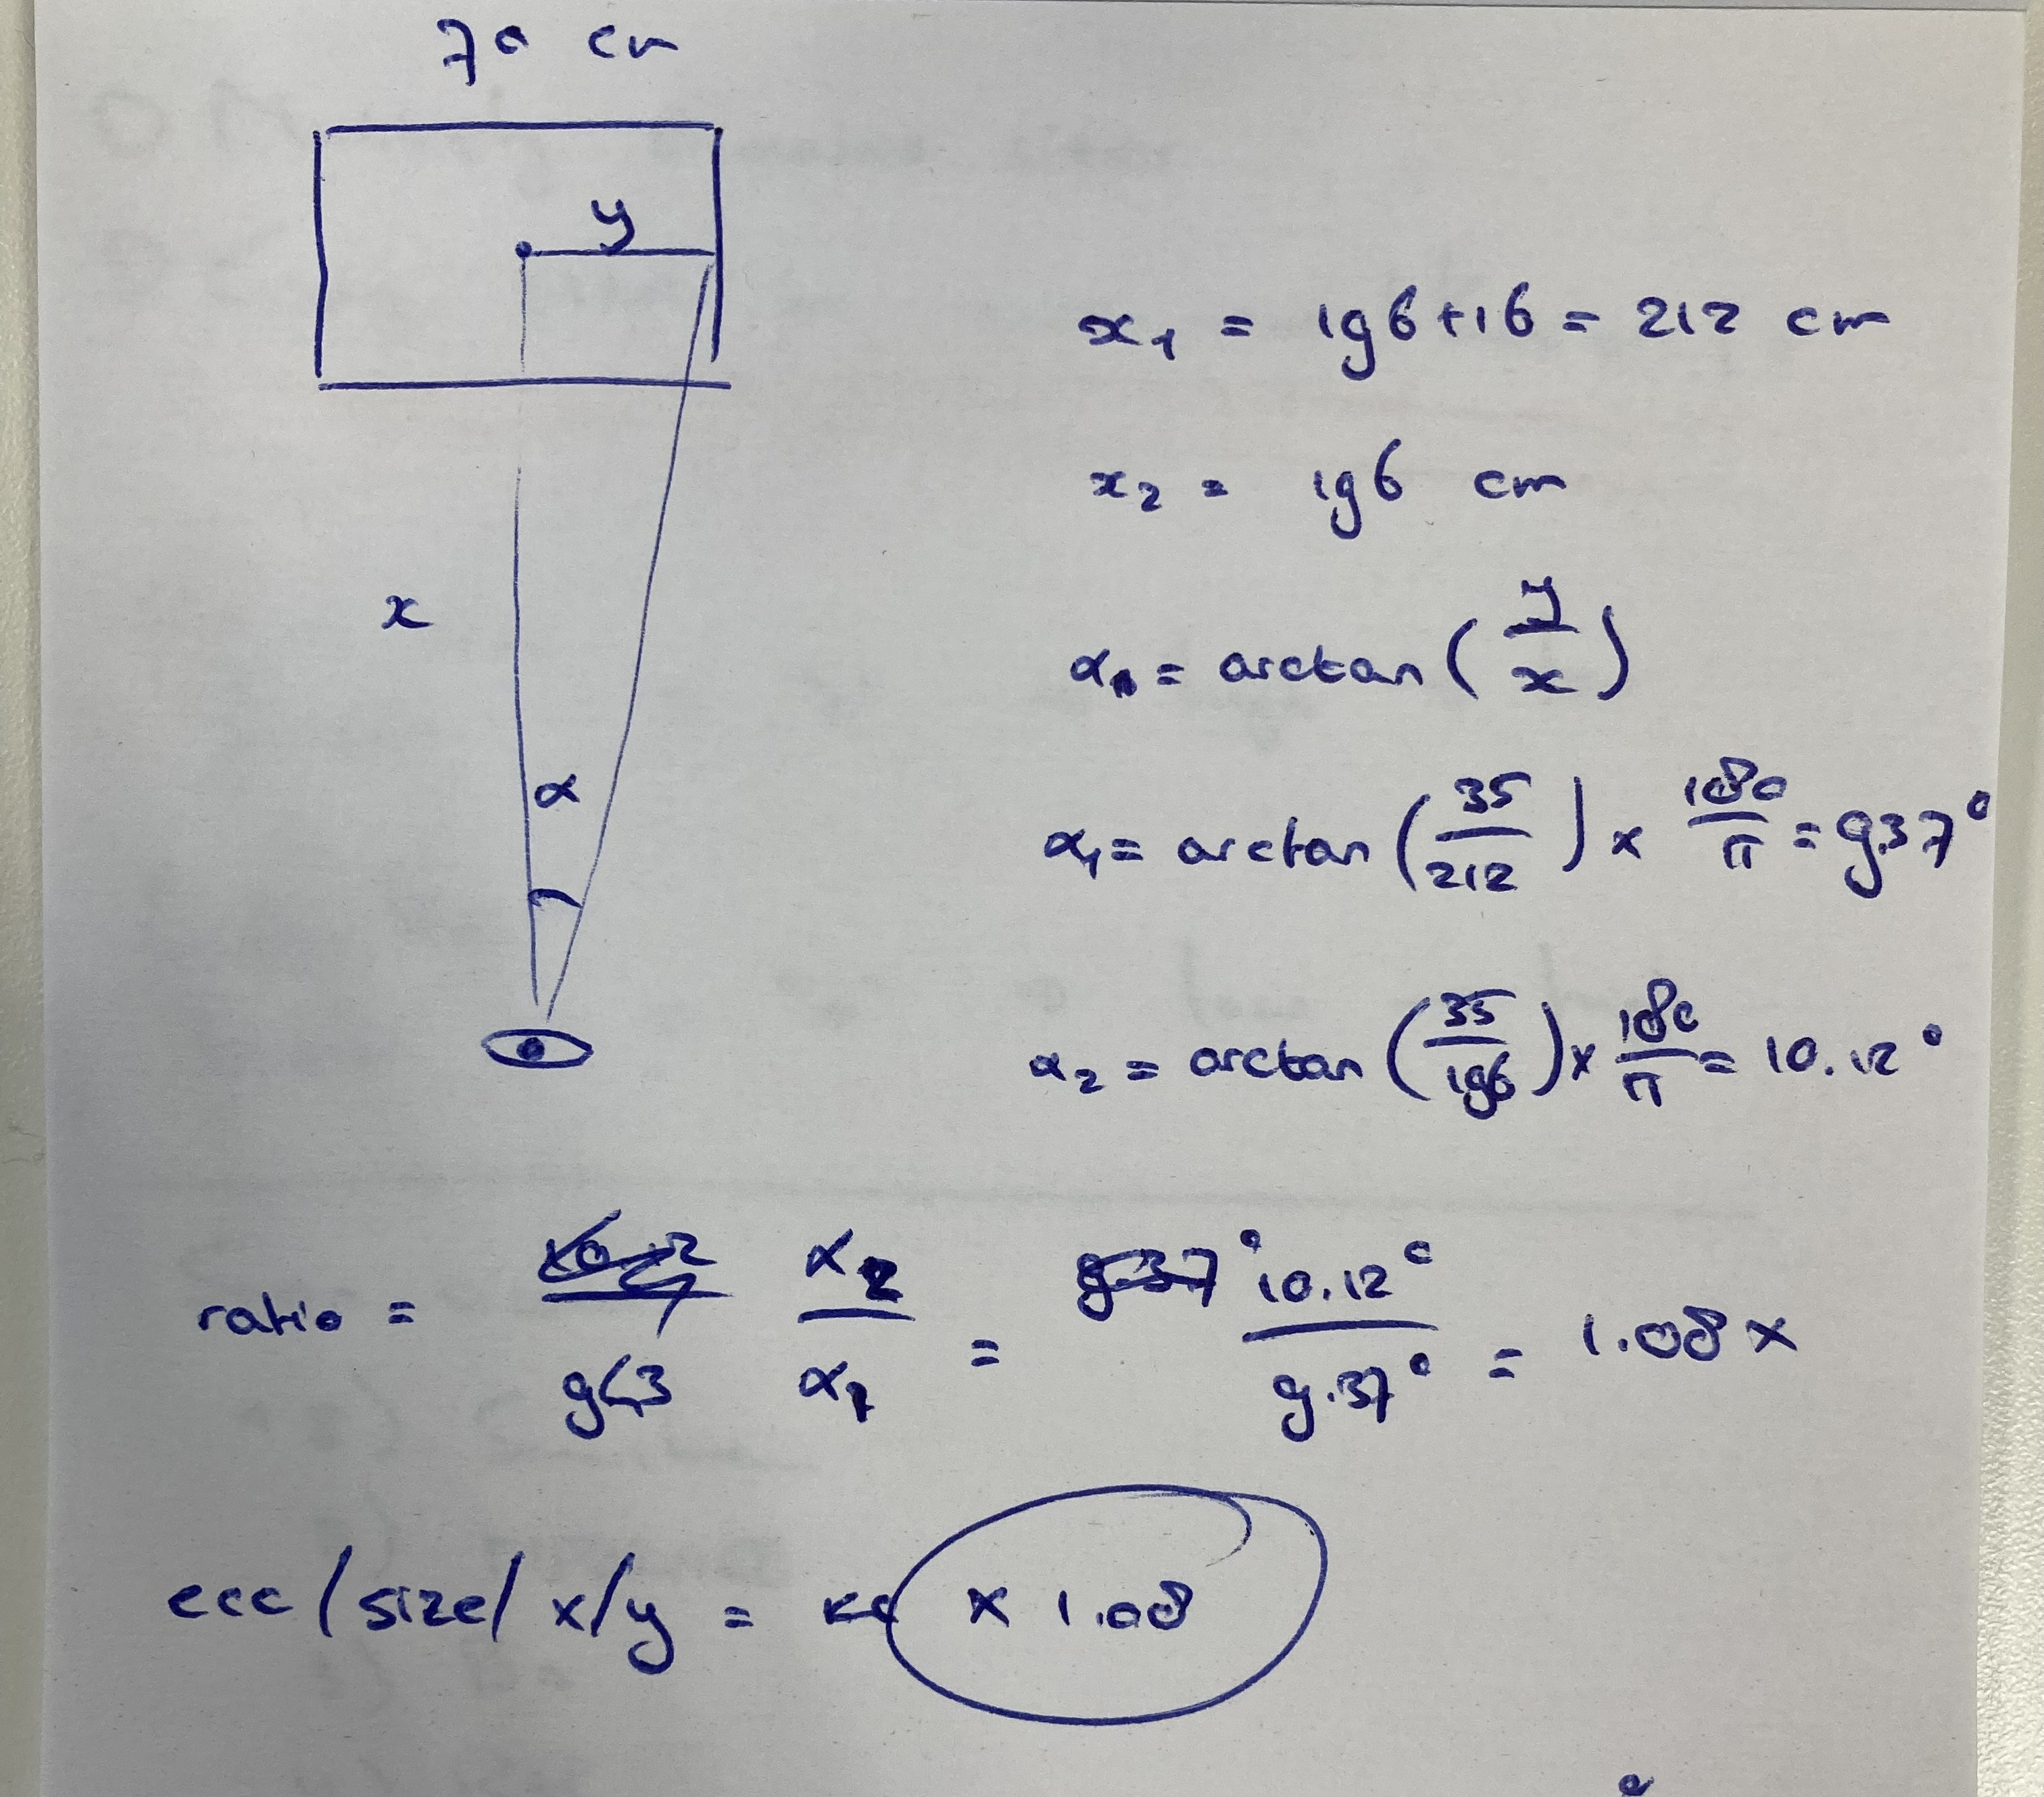

In [2]:
Image(filename="../imgs/boldscreen_increase_ratio.jpg")

This calculation shows that the x/y-location, eccentricity, and size are increased by a factor of `1.08` with the new BOLD-screen location. Therefore, the stimulus sizes and pRF-location have been updated **AFTER** running `call_sizeresponse`, so after fitting the DN-model with iterative fit.

In [3]:
%reload_ext autoreload
%autoreload 2

In [115]:
from linescanning import utils,prf,glm
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import nideconv as nd
from scipy.stats import sem
from prfpy.stimulus import PRFStimulus2D
import os
import pandas as pd
opj = os.path.join

warnings.simplefilter('ignore')
project_dir = os.environ.get("DIR_PROJECTS")
base_dir = os.path.join(project_dir, 'hemifield')

plot_vox = 359

Fetch the files representing the functional data (`bold.mat` > `call_linerecon`), experiment log file `events.tsv` > `exptools2`), regressor file (`physio.txt`) and mat-file (`physio.mat`) physio files (`call_spmphysio`). `run_files` collects all these files in a list, from which we can then pick the required files and store them in their respective variable

In [193]:
# Load data
sub         = '003'
ses         = 3
task        = "task-SR"
run         = [3,4,6]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")

df_func = []
df_onsets = []
df_physio = []
for ix,rr in enumerate(run):

    print(f"Processing run-{rr}")

    run_files   = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}", f"run-{rr}"], func_dir)
    func_file   = utils.get_file_from_substring("bold.mat", run_files, return_msg=None)
    exp_file    = utils.get_file_from_substring("events.tsv", run_files, return_msg=None)
    physio_file = utils.get_file_from_substring("physio.txt", run_files, return_msg=None)
    physio_mat  = utils.get_file_from_substring("physio.mat", run_files, return_msg=None)

    print(f" Func data: \t{func_file}")
    print(f" Exptools: \t{exp_file}")
    print(f" Regressors: \t{physio_file}")
    print(f" Heart rate: \t{physio_mat}")

    bp_type = "rolling"
    window = None

    func = utils.ParseFuncFile(func_file, 
                            subject=1, 
                            run=ix+1, 
                            deleted_first_timepoints=50, 
                            deleted_last_timepoints=50,
                            bp_filter=bp_type,
                            window_size=window)
                            
    onset = utils.ParseExpToolsFile(exp_file,
                                    subject=func.subject,
                                    run=func.run,
                                    delete_vols=(func.deleted_first_timepoints),
                                    TR=func.TR)         

    if physio_file != None:
        physio = utils.ParsePhysioFile(physio_file,
                                    physio_mat=physio_mat,
                                    subject=func.subject,
                                    run=func.run,
                                    TR=func.TR,
                                    deleted_first_timepoints=func.deleted_first_timepoints,
                                    deleted_last_timepoints=func.deleted_last_timepoints)
                                
    # Fetch dataframes
    onset_df    = onset.get_onset_df(index=False)
    filtered    = func.dct_psc_rol.reset_index()
    physio_df   = physio.get_physio(index=False)

    # append to list
    df_func.append(filtered)
    df_onsets.append(onset_df)
    df_physio.append(physio_df)

df_func     = pd.concat(df_func).set_index(['subject', 'run', 't'])
df_onsets   = pd.concat(df_onsets).set_index(['subject', 'run', 'event_type'])
df_physio   = pd.concat(df_physio).set_index(['subject', 'run', 't'])
df_func.head()

Processing run-3
 Func data: 	/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat
 Exptools: 	/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_events.tsv
 Regressors: 	/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_physio.txt
 Heart rate: 	/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_physio.mat
Processing run-4
 Func data: 	/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-4_bold.mat
 Exptools: 	/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-4_events.tsv
 Regressors: 	/mnt/export/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-4_physio.txt
 Heart rate: 	/mnt/export/data1

vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                              
1       1   0.000 -13.891742  18.961040   2.063555   3.682374  18.408554   
            0.105   2.888111   1.986200   0.264139 -19.847313  10.156828   
            0.210  14.478710   3.458475 -10.143950  12.808427   2.470381   
            0.315  -0.892761   2.037522   9.948232  10.508973   2.991287   
            0.420  -2.172973 -12.968266  -5.167143  19.498413  -3.685570   

                       vox 5      vox 6     vox 7     vox 8     vox 9  ...  \
subject run t                                                          ...   
1       1   0.000  -3.695518  -6.322668  7.888626 -0.710594  6.094123  ...   
            0.105  11.342183   0.616655  3.926540 -9.278136 -1.705915  ...   
            0.210  12.478609   1.801235 -9.651151  7.441659 -4.916455  ...   
            0.315  16.056643  15.093729  3.601104 -2.542463  8.589325  ...   
            0.420   3.078429   2.305972  1.143473  9.401456  5.093876  ...   

                     vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                              
1       1   0.000  -5.610656   1.466888 -25.425249   9.925952  23.816406   
            0.105  37.625996  -1.024690  54.549576  65.410065  29.830605   
            0.210  18.496466 -39.420109 -26.193413  20.526688  30.854065   
            0.315 -19.457424  30.023703  -3.505740 -12.246127  12.542195   
            0.420  15.934171   0.570486 -42.262344  -0.495996  36.378086   

                     vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                             
1       1   0.000  36.882214  -6.540277 -36.774769 -35.853073   4.625607  
            0.105 -17.018137  42.048325  44.971848 -22.749884 -24.342083  
            0.210 -31.180561 -15.022355  -7.922815 -83.307953  12.106176  
            0.315  -0.922859  28.065704  36.624054 -30.900723   3.338297  
            0.420 -20.713203  11.566335 -47.377197 -33.735947 -26.920324  

[5 rows x 720 columns]

In [194]:
# # Load data
# sub         = '003'
# ses         = 3
# task        = "task-SR"
# run         = 3
# func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")

# run_files   = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}", f"run-{run}"], func_dir)
# func_file   = utils.get_file_from_substring("bold.mat", run_files)
# exp_file    = utils.get_file_from_substring("events.tsv", run_files)
# physio_file = utils.get_file_from_substring("physio.txt", run_files)
# physio_mat  = utils.get_file_from_substring("physio.mat", run_files)

# print(f"Processing run-{run}")
# print(f" Func data: \t{func_file}")
# print(f" Exptools: \t{exp_file}")
# print(f" Regressors: \t{physio_file}")
# print(f" Heart rate: \t{physio_mat}")

# bp_type = "rolling"
# window = None
# func = utils.ParseFuncFile(func_file, 
#                            subject=1, 
#                            run=1, 
#                            deleted_first_timepoints=50, 
#                            deleted_last_timepoints=50,
#                            bp_filter=bp_type,
#                            window_size=window)
                           
# onset = utils.ParseExpToolsFile(exp_file,
#                                 subject=func.subject,
#                                 run=func.run,
#                                 delete_vols=(func.deleted_first_timepoints),
#                                 TR=func.TR)         

# physio = utils.ParsePhysioFile(physio_file,
#                                physio_mat=physio_mat,
#                                subject=func.subject,
#                                run=func.run,
#                                TR=func.TR,
#                                deleted_first_timepoints=func.deleted_first_timepoints,
#                                deleted_last_timepoints=func.deleted_last_timepoints)

# # Fetch dataframes
# onset_df    = onset.get_onset_df(index=True)
# physio_df   = physio.get_physio(index=True)
# raw         = func.get_raw(index=True)
# filtered    = func.dct_psc_rol

# # beginning of window = NaN
# print(f"Func data has shape {filtered.shape}")
# print(f"Physio has shape    {physio_df.shape}")
# filtered.head(10)

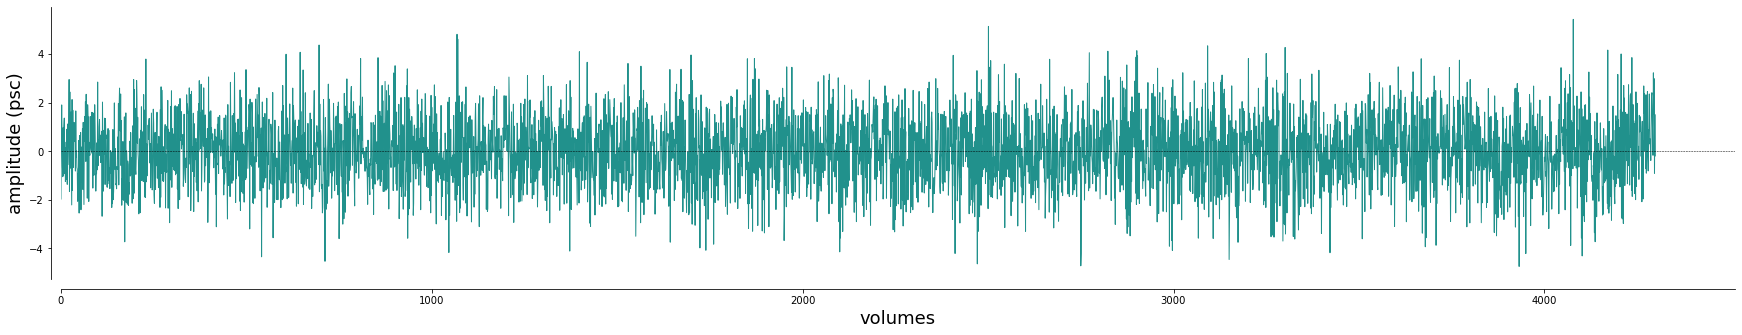

In [195]:
utils.LazyPlot(filtered[f'vox {plot_vox}'].values, 
               figsize=(30,5),
               x_label="volumes",
               y_label="amplitude (psc)",
               add_hline={'pos': 0, 'ls': '--', 'color': 'k', 'lw': 0.5},
               set_xlim_zero=True,
               sns_trim=False,
               font_size=18)


Mean heart rate = 0.0


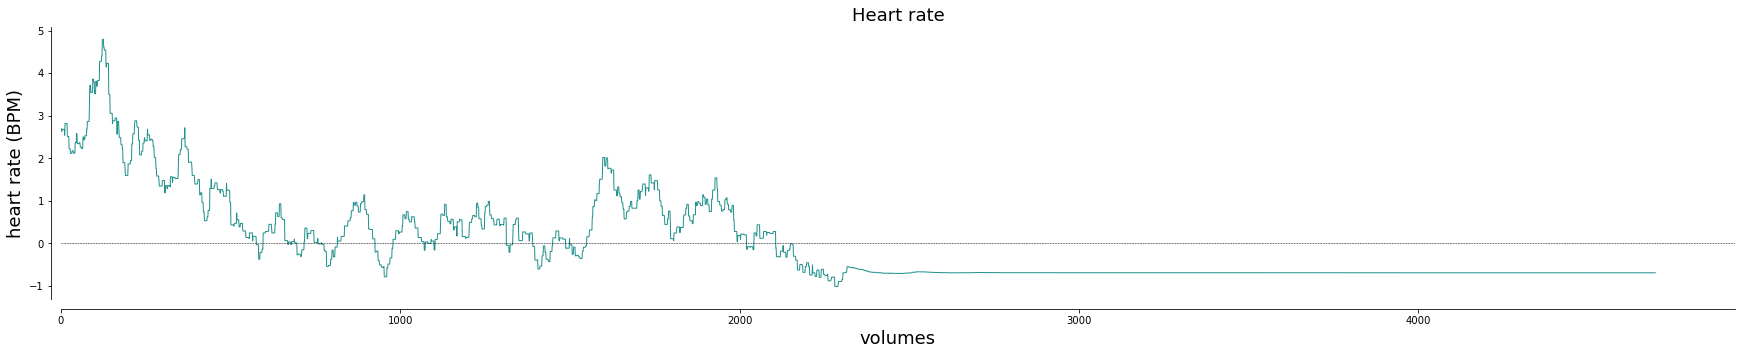

In [196]:
utils.LazyPlot(physio_df['hr'].values, 
               figsize=(30,5),
               x_label="volumes",
               y_label="heart rate (BPM)",
               title=f"Heart rate",
               add_hline={'pos': physio_df['hr'].values.mean(), 'ls': '--', 'color': 'k', 'lw': 0.5},
               set_xlim_zero=True,
               sns_trim=False,
               font_size=18)

print(f"Mean heart rate = {round(physio_df['hr'].values.mean(),2)}")

---
# Deconvolution

## Size-Response information

Here we fetch relevant pRF-parameters that are required to construct the size-response curve below (this is the same curve as in `derivatives/pycortex/<subject>/<subject>_hemi-?_desc-prf_sizeresponse.pdf`).

In [197]:
# collect subject data including Normalization parameters
subject_info = utils.CollectSubject(f"sub-{sub}", prf_dir=opj(project_dir, 'hemifield', 'derivatives', 'prf', f"sub-{sub}", 'ses-1'), cx_dir=opj(project_dir, 'hemifield', 'derivatives', 'pycortex', f"sub-{sub}"), settings='recent', hemi="lh", model="norm")

# initiate the SizeResponse class
SR = prf.SizeResponse(subject_info.prf_stim, subject_info.normalization_params, subject_info=subject_info)

# make the stimuli
SR.make_stimuli()

# make the curve
sr_curve1 = SR.make_sr_function(center_prf=True)

# stimsizes are in SR.stims_fill_sizes

Perform the deconvolution using nideconv. For now, the physio-regressors are excluded because they look unreliable (see plot of heart rate above..). There might have been something wrong with the PPU/Resp acquisition, but best to leave them out until we have a run with good physiology

## Model: no differentation between stimulus size

In [212]:
# create onset df with no differentiation between stimulus sizes > consider ALL stimulus sizes as 1 event type
all_stim_onsets = df_onsets.copy().reset_index()
all_stim_onsets['event_type'] = 'stim'
all_stim_onsets = all_stim_onsets.set_index(['subject', 'run', 'event_type'])
all_stim_onsets.head(10)

onset
subject run event_type           
1       1   stim        24.363776
            stim        26.655493
            stim        35.213706
            stim        36.855363
            stim        39.913720
            stim        42.180439
            stim        47.413652
            stim        50.055460
            stim        53.213640
            stim        60.755378

First, we run a deconvolution without differentiation between stimulus sizes: all events are considered the same, so we should get 1 HRF out. Theoretically, this should already scale with cortical depth

In [217]:
run_data    = df_func.reset_index()
run_data    = run_data.loc[(run_data['run'] == 1)].set_index(['subject', 'run', 't'])
run_onsets  = all_stim_onsets.reset_index()
run_onsets  = run_onsets.loc[(run_onsets['run'] == 1)].set_index(['subject', 'run', 'event_type'])
run_onsets

onset
subject run event_type            
1       1   stim         24.363776
            stim         26.655493
            stim         35.213706
            stim         36.855363
            stim         39.913720
...                            ...
            stim        372.703811
            stim        376.503695
            stim        386.603704
            stim        388.230752
            stim        392.345201

[78 rows x 1 columns]

In [222]:
# use 1 run for now, concatenating runs doesn't work yet and makes ridge regression complicated
use_data    = run_data.copy()
use_onsets  = run_onsets.copy()

# CSF/GM >> GM/WM
ribbon      = [356,363]
include_vox = np.arange(*ribbon)

min_int     = 0
max_int     = 12
n_regres    = 19
basis_sets  = "fir"
fs          = 1/func.TR

# don't use physio regressors > they're iffy
use_physio = False
if use_physio:
    physio_conf = physio_df.copy()
else:
    physio_conf = None

if basis_sets == "fir":

    print("Performing FIR with ridge regression")
    input_signal = pd.DataFrame(use_data)
    onsets = use_onsets.reset_index().drop(['subject', 'run'], axis=1).set_index('event_type').loc['stim'].onset
    
    ridge_models = {}
    for ix, signal in enumerate(input_signal.columns):
        if ix in include_vox:
            print(f" vox: {ix}")
            vox_signal = pd.DataFrame(input_signal.iloc[:,ix]).reset_index()
            vox_signal = vox_signal.drop(['subject', 'run'], axis=1).set_index('t')
            
            g_model = nd.ResponseFitter(input_signal=vox_signal, sample_rate=fs)

            # define events
            cond = use_onsets.reset_index().event_type.unique()
            cond = np.array(sorted([i for i in cond if i != 'nan']))

            # add events to model
            [g_model.add_event(str(i),
                               onsets=onsets,
                               basis_set=basis_sets,
                               n_regressors=n_regres,
                               interval=[min_int,max_int]) for i in cond]

            # fit
            g_model.fit(type="ridge")
            ridge_models[ix] = g_model
            
    print("Done")

else:
    print("Using Fourier basis sets")
    # initiate model
    fourier_model = nd.GroupResponseFitter(use_data,
                                           use_onsets,
                                           input_sample_rate=fs,
                                           concatenate_runs=False,
                                           confounds=physio_conf, 
                                           add_intercept=False)

    # define events
    cond = all_stim_onsets.reset_index().event_type.unique()
    cond = np.array(sorted([i for i in cond if i != 'nan']))
    print(f"Conditions are: {cond}")

    # add events to model
    [fourier_model.add_event(str(i),
                             basis_set=basis_sets,
                             n_regressors=n_regres,
                             interval=[min_int,max_int]) for i in cond]

    # fit
    fourier_model.fit(type="ols")
    print("Done")

    # extract condition wise timecourses
    tc_condition = fourier_model.get_conditionwise_timecourses()

    # extract time axis > only works this way with 1 event.
    time_axis = tc_condition.reset_index()['time'].values

Performing FIR with ridge regression
 vox: 356
 vox: 357
 vox: 358
 vox: 359
 vox: 360
 vox: 361
 vox: 362
Done


### FIR w/ Ridge regression vs Fourier basis sets

First I averaged over the grey-matter voxels to get 1 HRF:

Performed with ridge regression


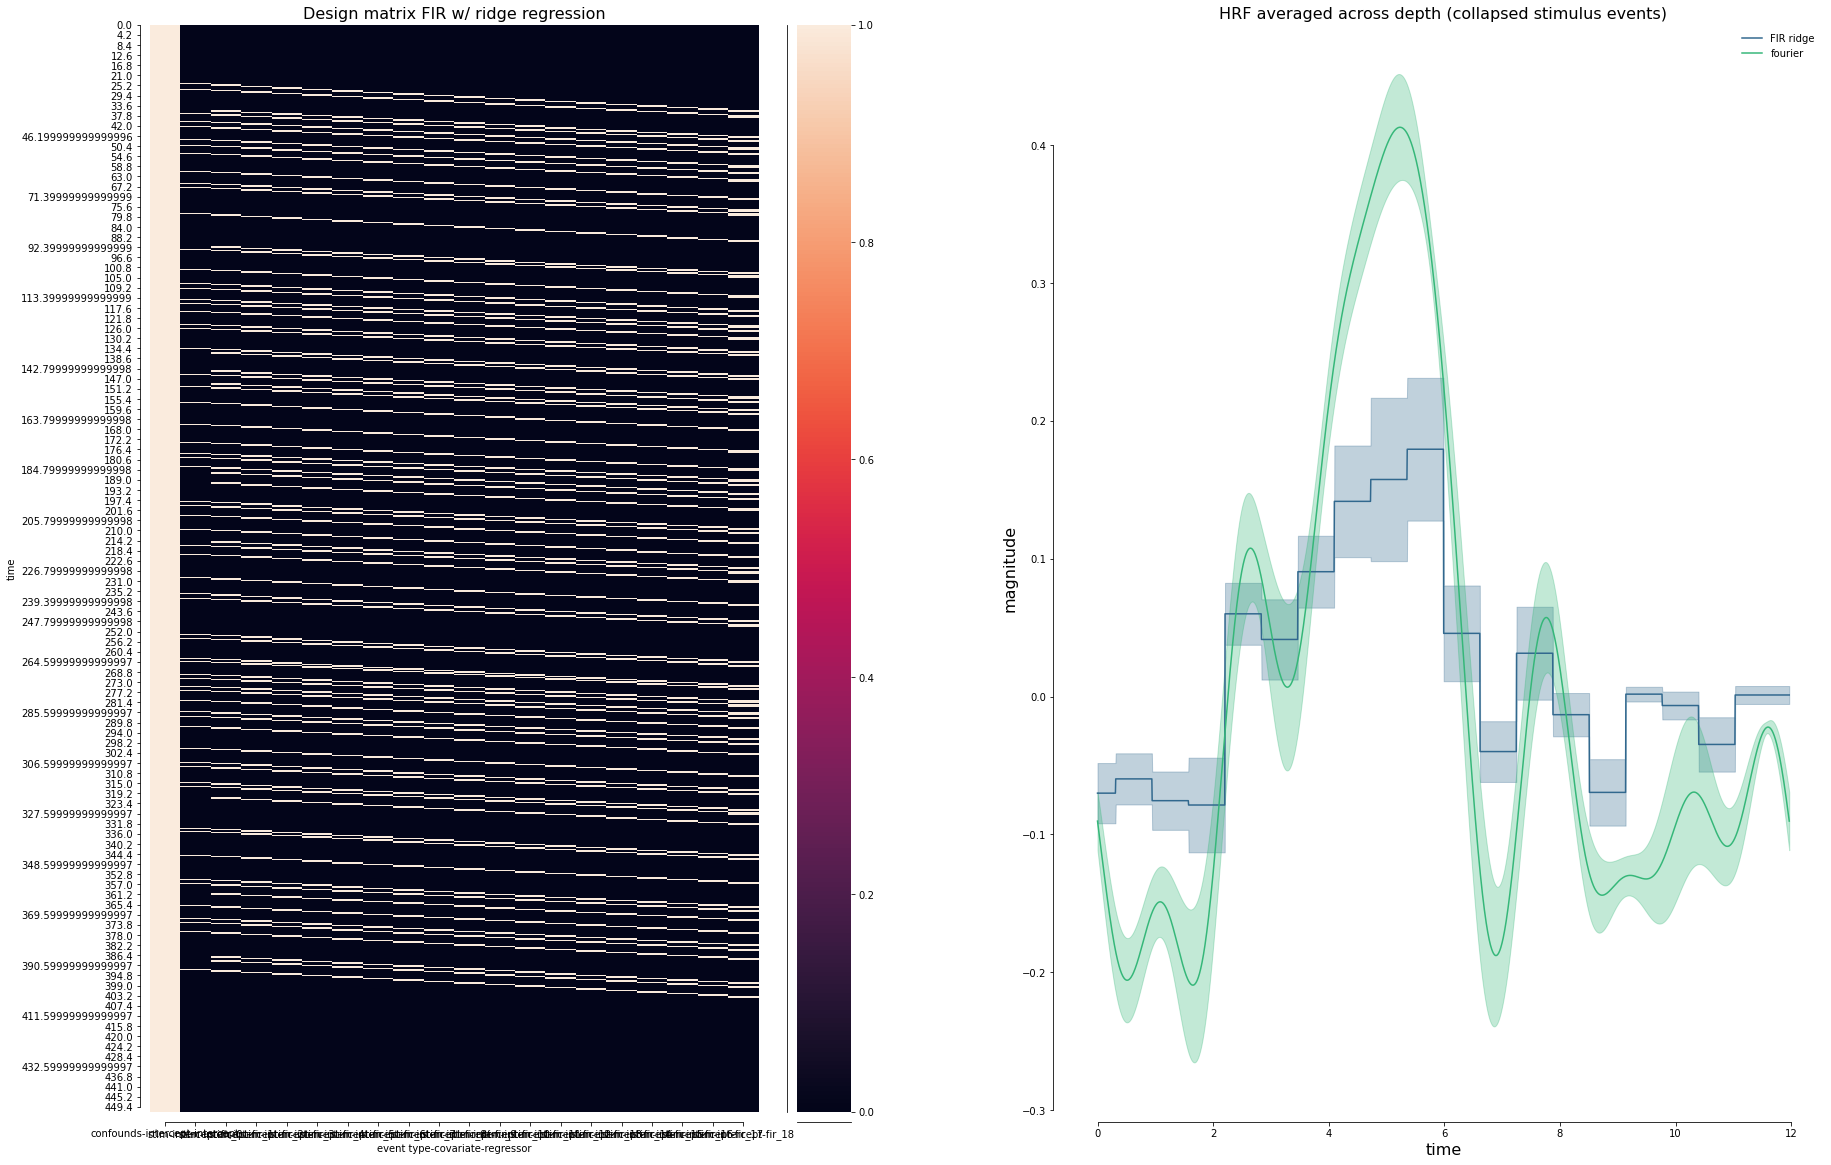

In [223]:
# try:
if bool(ridge_models):

    fig = plt.figure(figsize=(30,20))
    gs = fig.add_gridspec(1,2)

    ax1 = fig.add_subplot(gs[0])
    sns.heatmap(ridge_models[include_vox[0]].X, ax=ax1)
    ax1.set_title("Design matrix FIR w/ ridge regression", fontsize=16)

    
    df_fourier = fourier_model.get_conditionwise_timecourses()
    fourier = []
    ridge   = []
    for idx, ii in enumerate(range(*ribbon)):            
        tc_ridge = ridge_models[ii].get_timecourses().values
        ridge.append(tc_ridge)

        tc_fourier = df_fourier.loc['stim'][f'vox {ii}'].values
        fourier.append(tc_fourier)

    # average over voxels
    ridge_avg       = np.squeeze(np.array(ridge).mean(axis=0))
    ridge_sem       = np.squeeze(sem(ridge))
    fourier_avg     = np.array(fourier).mean(axis=0)
    fourier_sem     = sem(fourier)

    ax2 = fig.add_subplot(gs[1])
    utils.LazyPlot([ridge_avg, fourier_avg],
                    xx=time_axis,
                    error=[ridge_sem, fourier_sem],
                    axs=ax2,
                    x_label="time",
                    y_label="magnitude",
                    font_size=16,
                    title="HRF averaged across depth (collapsed stimulus events)",
                    line_width=1.5,
                    labels=['FIR ridge', 'fourier'])

    print("Performed with ridge regression")
# except Exception:
#     print("Run ridge regression first.")

Below the HRFs for each voxel in the ribbon

Performed with Fourier basis sets


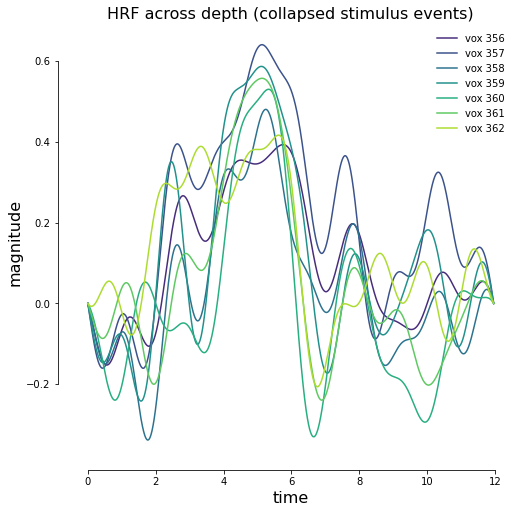

In [224]:
# try:
df_fourier = fourier_model.get_conditionwise_timecourses()
fourier = []
ridge   = []
for idx, ii in enumerate(range(*ribbon)):            
    tc_ridge = ridge_models[ii].get_timecourses().values
    ridge.append(tc_ridge)

    tc_fourier = df_fourier.loc['stim'][f'vox {ii}'].values
    tc_fourier += abs(tc_fourier[0])
    fourier.append(tc_fourier)

labels = [f'vox {ii}' for ii in include_vox]
utils.LazyPlot(fourier,
                xx=time_axis,
                figsize=(8,8),
                x_label="time",
                y_label="magnitude",
                font_size=16,
                title="HRF across depth (collapsed stimulus events)",
                line_width=1.5,
                labels=labels)

print("Performed with Fourier basis sets")
# except Exception:
#     print("Run ridge regression first.")

## Model: each stimulus size = event (fourier)

In [136]:
min_int     = 0
max_int     = 11
n_regres    = 11
fs          = 1/func.TR

use_physio = False
if use_physio:
    physio_conf = physio_df.copy()
else:
    physio_conf = None

g_model = nd.GroupResponseFitter(filtered,
                                 onset_df,
                                 input_sample_rate=fs,
                                 concatenate_runs=False,
                                 confounds=physio_conf, 
                                 add_intercept=False)

cond = onset_df.reset_index().event_type.unique()
cond = np.array(sorted([i for i in cond if i != 'nan']))
print(f"Conditions are: {cond}")
[g_model.add_event(str(i),
                   basis_set='fourier',
                   n_regressors=n_regres,
                   interval=[min_int,max_int]) for i in cond]
           
g_model.fit()
print("Done")

Conditions are: ['1.140879298089248' '1.853928859395028' '2.014613132977678'
 '2.13914868391734' '3.5652478065289']
Done


Here I reset the index of the deconvolution dataframe, so that I can use `.loc` to select timecourses of specific voxels based on `event type`.

Below is the procedure for getting the average response across the ribbon in response to the different stimulus sizes. First, I specify the voxels that are part of the cortical ribbon, eg., `[356,364]`. Then, I loop through the voxel IDs, extract the HRF-timecourse, and average this. Because of the list-nature of the output, I can use `LazyPlot` quite easily to plot it. I also extract the `maximum value` of the `averaged HRF` to plot on the size-response function. Ideally, this should lie, in order from smallest stimulus size to largest stimuls size, on the size response curve.

In [139]:
# fetch condition-wise timecourses
tc_condition    = g_model.get_conditionwise_timecourses()
time_axis       = tc_condition.groupby('time').mean().reset_index()['time'].values

ribbon          = [356,363]
stim_avg        = []
stim_sem        = []
for size_ix, sizes in enumerate(cond):

    # stimulus-specific average
    voxel_avg = []
    for ii in range(*ribbon):
        tc = tc_condition.loc[sizes][f'vox {ii}'].values
        voxel_avg.append(tc)

    # average over voxels
    voxel_avg = np.array(voxel_avg).mean(axis=0)
    stim_sem.append(sem(voxel_avg))
    stim_avg.append(voxel_avg)

# normalize HRFs
voxel_avg_norm = voxel_avg/np.amax(stim_avg)

# get max amplitude so they're comparable to size-response magnitude
max_vals = np.amax(stim_avg/np.amax(stim_avg), axis=1)

The stimulus sizes on which the SR-curve is based were not corrected for the displacement of the BOLD-screen. Therefore, we need to reduce the stimulus-sizes by a factor of 1.08 (see calculation at the top of the page).

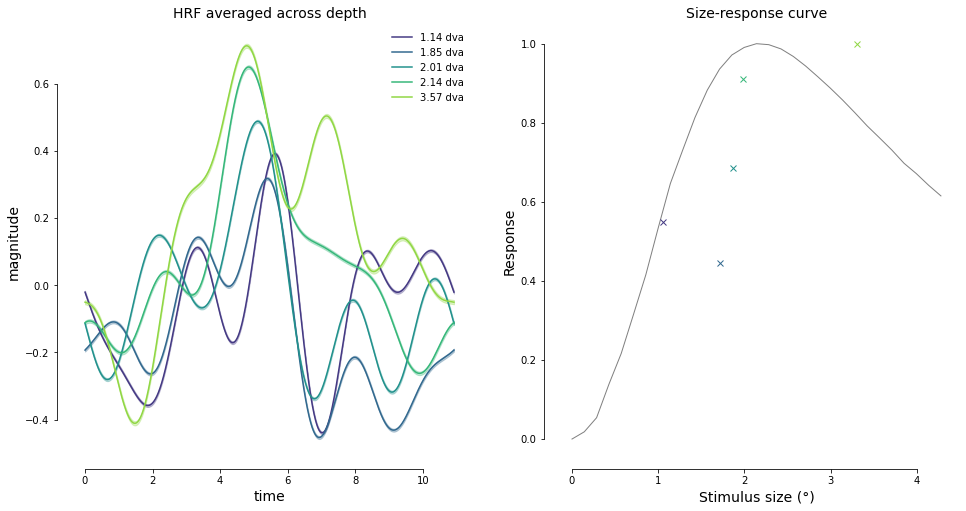

In [152]:
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0])
utils.LazyPlot(stim_avg,
               xx=time_axis,
               error=stim_sem,
               axs=ax1,
               x_label="time",
               y_label="magnitude",
               font_size=14,
               title="HRF averaged across depth",
               line_width=1.5,
               figsize=(8,8),
               labels=[f"{round(float(ii),2)} dva" for ii in cond])

ax2 = fig.add_subplot(gs[1])
utils.LazyPlot(sr_curve1, 
               xx=SR.stims_fill_sizes,
               color=(128/255, 128/255, 128/255),
               axs=ax2,
               y_label="Response",
               x_label="Stimulus size (°)",
               title="Size-response curve",
               font_size=14)

cols = sns.color_palette('viridis', len(cond))
for ix,kk in enumerate(max_vals):
    ax2.plot(cond.astype(float)[ix]/1.08, kk, color=cols[ix], marker='x')               

Above we can see pretty decent HRF-responses in the left panel. We see that the largest stimulus size evokes the largest HRF with smaller stimulus sizes having lower HRF amplitudes. Despite that this is expected, I think it's still cool and promising. As for the SR-curve, we can see that the order is correct: smaller stimulus sizes = lower HRF. However, the normalized amplitudes are somewhat shifted compared to where we expected them to be based on the SR-curve. This is because of the way I normalized the maximums of the HRFs. See [this](https://github.com/spinoza-centre/pRFline/issues/4#issuecomment-1028001384) issue in the `pRFline`-repository.

Below I plotted the HRF for each voxel in the cortical ribbon in response to all stimulus sizes:

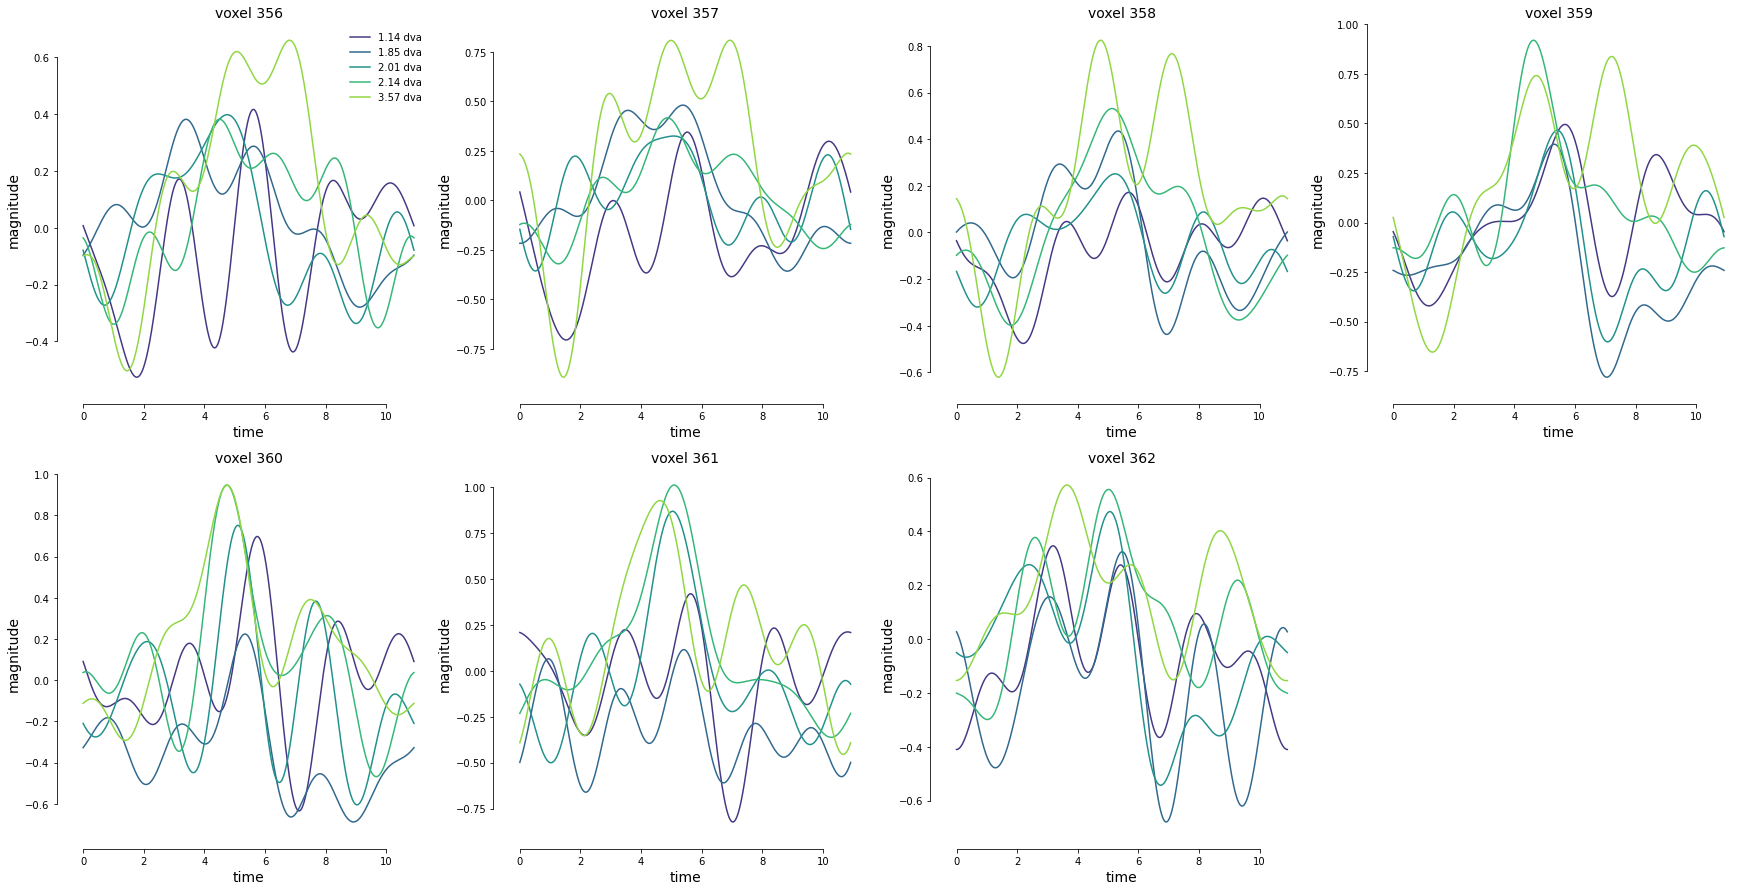

In [155]:
vox = np.arange(*ribbon)

fig = plt.figure(figsize=(30,15))
gs = fig.add_gridspec(2,(len(vox)//2)+1)
for ix,voxel in enumerate(vox):

    # fetch data from specific voxel for each stimulus size
    data = []
    for idc,size in enumerate(cond):
        vox_data = tc_condition[f'vox {voxel}'][size].values
        data.append(vox_data)

    # draw legend once
    if ix == 0:
        labels = [f"{round(float(ii),2)} dva" for ii in cond]
    else:
        labels = None
    
    # plot all stimulus sizes for a voxel
    ax = fig.add_subplot(gs[ix])
    utils.LazyPlot(data,
                   xx=time_axis,
                   axs=ax,
                   x_label="time",
                   y_label="magnitude",
                   font_size=14,
                   title=f"voxel {voxel}",
                   line_width=1.5,
                   labels=labels)